In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim

import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [20]:
df = pd.read_csv('/workspace/Storage_fast/PointCloudAugmentation/PRADA/prada-protecting-against-dnn-model-stealing-attacks/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
def cube_data(df):
    """Creates an n-d array from data frame"""
    if "label" in df.columns:
        imgs = df.drop("label", axis = 1).values # iloc: integer indexing, values: numpy ndarray
    else:
        imgs = df.values
    ntot = imgs.shape[0]         # number of rows

    imgs = imgs / 255
    # create a ntrain * 28 * 28 ndarray of training set
    cube = np.ndarray(shape = (ntot, 1, 28, 28), dtype = "float")
    for i in range(0, ntot):
        cube[i, 0, :, :] = imgs[i, :].reshape(28, 28)
    return cube

In [22]:
cube = cube_data(df)
ntot = cube.shape[0]

In [23]:
ntrain = np.floor(ntot * .6)
train_indices = np.random.randint(0, int(ntot), size = int(ntrain))

nvalid = ntot - ntrain
valid_indices = np.setdiff1d(list(range(0, ntot)), train_indices)

In [24]:
# Create a tensor containing the correct labels
labels = df['label'].values
# break data into training and validation sets
train_cube = torch.FloatTensor(cube[train_indices, :, :, :])
valid_cube = torch.FloatTensor(cube[valid_indices, :, :, :])

train_labels = torch.from_numpy(labels[train_indices])
valid_labels = torch.from_numpy(labels[valid_indices])
print(train_cube.size())
print(train_labels.size())
print(valid_cube.size())
print(valid_labels.size())

torch.Size([25200, 1, 28, 28])
torch.Size([25200])
torch.Size([23000, 1, 28, 28])
torch.Size([23000])


In [25]:
trainset = torch.utils.data.TensorDataset(train_cube, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, 
                                          shuffle = True)

testset = torch.utils.data.TensorDataset(valid_cube, valid_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, 
                                          shuffle = True)

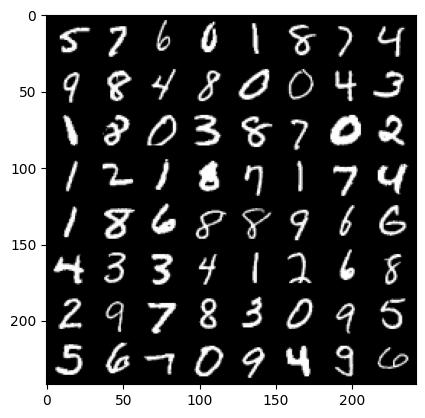

In [26]:
def imshow(img):
    img = img # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [27]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
def relu(input):
  return 0.563059 + 0.5*input + 0.078047*input*input
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 120)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = relu(F.max_pool2d(self.conv1(x), 2))
        x = relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = relu(self.fc1_drop(self.fc1(x)))
        x = relu(self.fc2(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net
net.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [30]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 30
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    net.train()
    
    total = 0
    # training our net
    for idx, (image, label) in enumerate(trainloader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = net(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
                
    accuracy_train = total / len(trainset)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our net
    net.eval()
    total = 0
    for idx, (image, label) in enumerate(testloader):
        image, label = image.to(device), label.to(device)
        pred = net(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(testset)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/30   Training loss: 0.2578   Testing loss: 0.1921   Train accuracy: 0.9266   Test accuracy: 0.9454  
Epoch: 5/30   Training loss: 0.2176   Testing loss: 0.1670   Train accuracy: 0.9398   Test accuracy: 0.9503  
Epoch: 10/30   Training loss: 0.1835   Testing loss: 0.1423   Train accuracy: 0.9471   Test accuracy: 0.9561  
Epoch: 15/30   Training loss: 0.1602   Testing loss: 0.1317   Train accuracy: 0.9540   Test accuracy: 0.9608  
Epoch: 20/30   Training loss: 0.1434   Testing loss: 0.1317   Train accuracy: 0.9564   Test accuracy: 0.9581  
Epoch: 25/30   Training loss: 0.1335   Testing loss: 0.1236   Train accuracy: 0.9610   Test accuracy: 0.9609  


In [31]:
torch.save(net.state_dict(), "/workspace/Storage_fast/PointCloudAugmentation/PRADA/prada-protecting-against-dnn-model-stealing-attacks/targetmodel.pth")

In [34]:
from torchvision.utils import save_image
for idx, (image, label) in enumerate(trainloader):
        image, label = image ,label
        print(image.shape)
        img1 = images[0] #torch.Size([3,28,28]
        # img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
        save_image(img1, '/workspace/Storage_fast/PointCloudAugmentation/PRADA/prada-protecting-against-dnn-model-stealing-attacks/img1.png')
        break

torch.Size([64, 1, 28, 28])


In [ ]:
import client